In [1]:
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Subset, TensorDataset
import itertools
from  torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split  

In [2]:
from functions import *
from CustomDataset import CustomDataset

Defining some globals with the path to both files you just downloaded:

In [3]:
TRAIN_DATA_PATH = '../dataset/sign_mnist_train/sign_mnist_train.csv'
TEST_DATA_PATH = '../dataset/sign_mnist_test/sign_mnist_test.csv'

RANDOM_SEED = 30

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print("Using device: {}".format(DEVICE))

Using device: cpu


Taking a look at how the data looks like within the csv file:

In [6]:
with open(TRAIN_DATA_PATH) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

Each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image.
The original images have a resolution of 28x28, which sums up to 784 pixels.

### Read the dataset


In [7]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


### Saving 10% fraction as new input

In [9]:
# Split the data into 90% and 10%  
#test_df, new_fraction = train_test_split(test_df, test_size=0.1, random_state=RANDOM_SEED)  
  
# Save the 10% data to a new file  
#new_fraction.to_csv('../dataset/sign_mnist_test_new.csv', index=False)  

In [10]:
train_df.shape

(27455, 785)

In [11]:
test_df.shape

(7172, 785)

In [12]:
# Displaying class labels (training data)
np.unique(train_df["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [13]:
# Displaying class labels (test data)
np.unique(test_df["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [14]:
# Computing the number of objects for each class (training data)
np.bincount(train_df["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162,    0, 1114,
       1241, 1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082,
       1225, 1164, 1118])

In [15]:
y_train = train_df['label']
y_test = test_df['label']

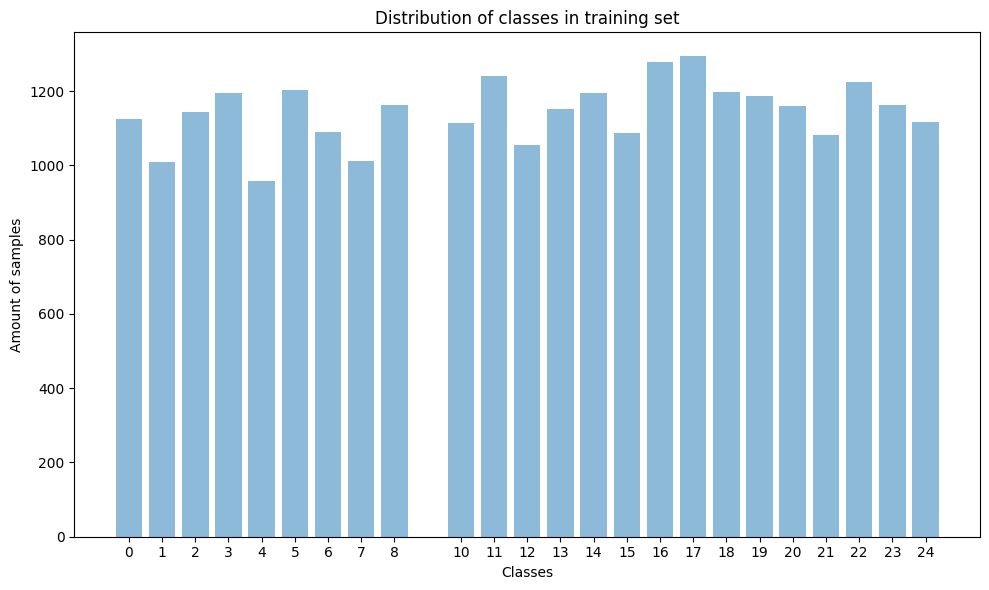

In [16]:
plot_class_distribution(y_train, 'Distribution of classes in training set')

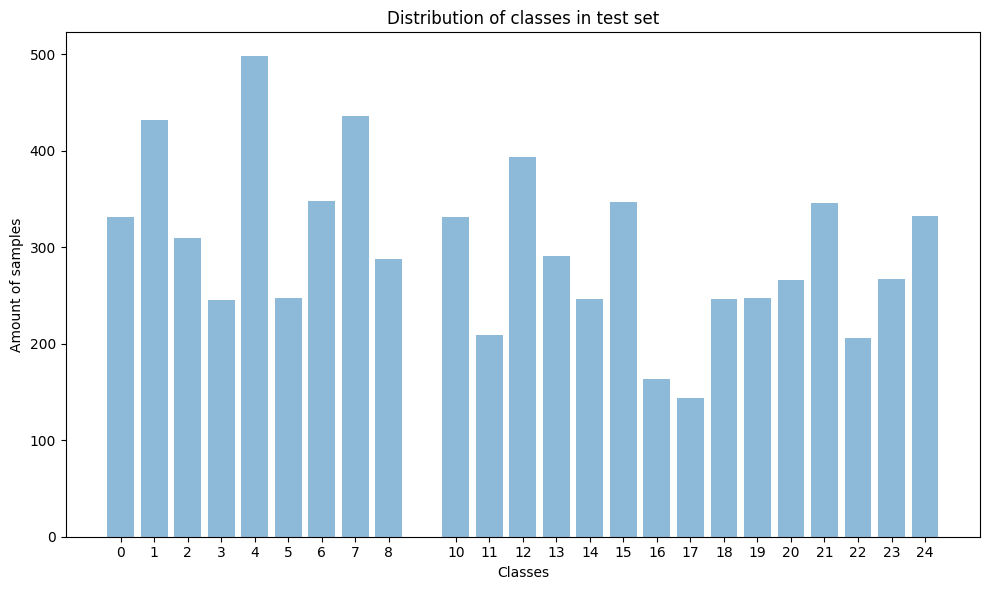

In [17]:
plot_class_distribution(y_test, 'Distribution of classes in test set')

In order to be able to successfully run the neural net, we need to have the consecutive class labels starting with zero. Hence, we will just relabel those objects which have class labels greater than 9 by subtracting one from the original label, thus obtaining the consecutive labels.

In [18]:
train_df["label"] = train_df["label"].apply(adjust_class_labels)

In [19]:
# Verifying the new class labels
np.unique(train_df["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [20]:
test_df["label"] = test_df["label"].apply(adjust_class_labels)

In [21]:
# Verifying the new class labels
np.unique(test_df["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [22]:
y_train = train_df['label']
y_test = test_df['label']

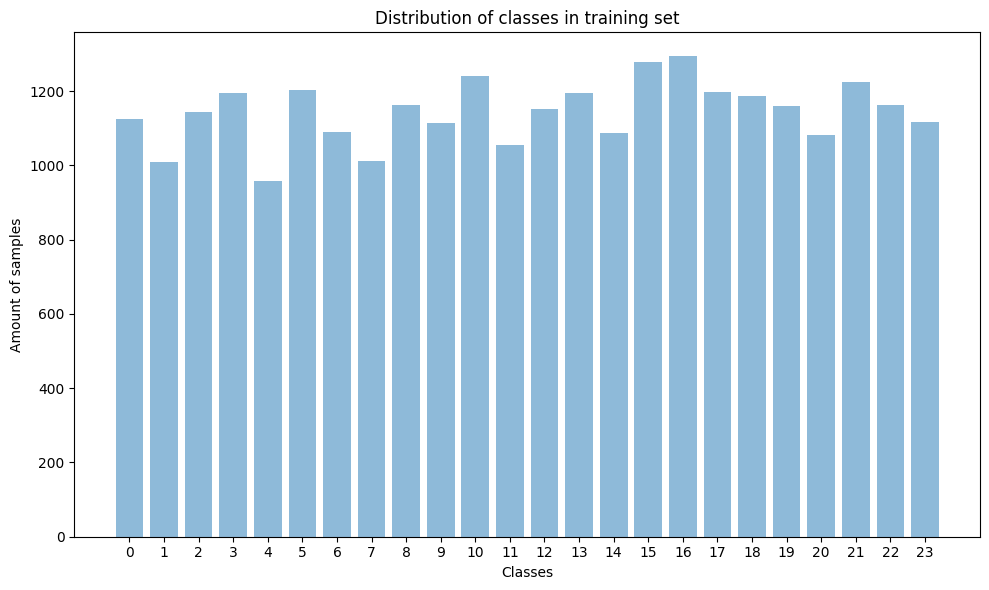

In [23]:
plot_class_distribution(y_train, 'Distribution of classes in training set')

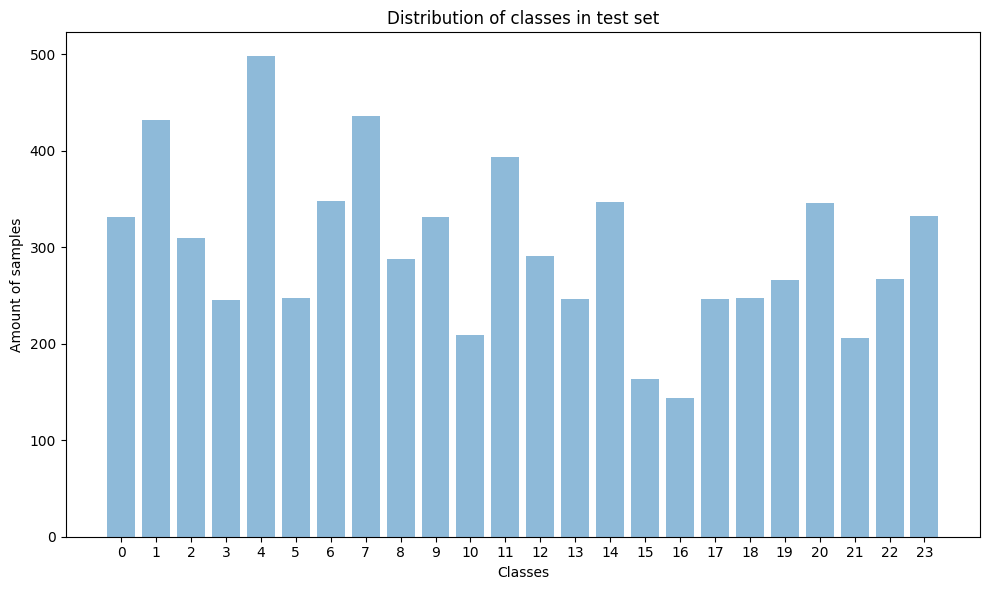

In [24]:
plot_class_distribution(y_test, 'Distribution of classes in test set')

In [25]:
drop_column(train_df, 'label')
drop_column(test_df, 'label')

## Creating Datasets

In [26]:
target = y_train.values
features = train_df.values

target_test = y_test.values
features_test = test_df.values

### Reshaping the training/testing data for NN

In [27]:
features = features.reshape(-1, 1, 28, 28)
features_test = features_test.reshape(-1, 1, 28, 28)

### Rescaling the features (training + testing)

In [28]:
features_scaled = features / 255
features_test_scaled = features_test / 255

In [29]:
print("First 3 samples in features_scaled:")  
for i in range(3):  
    print(features_scaled[i])  

First 3 samples in features_scaled:
[[[0.41960784 0.4627451  0.49803922 0.5254902  0.54509804 0.56078431
   0.57254902 0.58823529 0.6        0.61176471 0.61960784 0.62745098
   0.63921569 0.64705882 0.62352941 0.65098039 0.65882353 0.66666667
   0.66666667 0.67058824 0.67058824 0.67058824 0.6745098  0.67058824
   0.67058824 0.66666667 0.66666667 0.6627451 ]
  [0.43529412 0.4745098  0.50588235 0.52941176 0.55294118 0.56470588
   0.58039216 0.59215686 0.60392157 0.61568627 0.62745098 0.63921569
   0.64313725 0.66666667 0.46666667 0.59607843 0.67058824 0.67058824
   0.66666667 0.67058824 0.6745098  0.6745098  0.6745098  0.6745098
   0.6745098  0.67058824 0.67058824 0.66666667]
  [0.44313725 0.48235294 0.51372549 0.5372549  0.55686275 0.56862745
   0.58823529 0.59607843 0.60784314 0.61960784 0.63137255 0.63921569
   0.64313725 0.6745098  0.41176471 0.55686275 0.66666667 0.67058824
   0.67058824 0.67058824 0.6745098  0.6745098  0.67843137 0.67843137
   0.6745098  0.67058824 0.67058824 0.670

In [30]:
print("\nFirst 3 samples in features_test_scaled:")  
for i in range(3):  
    print(features_test_scaled[i])  


First 3 samples in features_test_scaled:
[[[0.58431373 0.58431373 0.58823529 0.58823529 0.58823529 0.59215686
   0.59215686 0.58823529 0.59215686 0.59607843 0.59607843 0.59607843
   0.59607843 0.59607843 0.6        0.6        0.59215686 0.59607843
   0.59607843 0.6        0.59607843 0.59607843 0.59215686 0.59215686
   0.58823529 0.58823529 0.58823529 0.58431373]
  [0.58823529 0.58823529 0.58823529 0.59607843 0.59607843 0.59215686
   0.59607843 0.59607843 0.59607843 0.59607843 0.59607843 0.6
   0.60392157 0.6        0.60392157 0.60392157 0.6        0.60392157
   0.6        0.60392157 0.6        0.6        0.59607843 0.59607843
   0.59607843 0.59215686 0.58823529 0.59215686]
  [0.58823529 0.59215686 0.59215686 0.59607843 0.59607843 0.59607843
   0.6        0.6        0.59607843 0.59607843 0.59607843 0.6
   0.60392157 0.60392157 0.60784314 0.60784314 0.60392157 0.60392157
   0.60784314 0.60784314 0.60784314 0.60784314 0.60392157 0.6
   0.6        0.59215686 0.59215686 0.59607843]
  [0.58

In [31]:
print(target.nbytes)
print(features_scaled.nbytes)

219640
172197760


### Converting NumPy arrays to Torch tensors (training)

In [32]:
y_train = torch.from_numpy(target).float()
x_train = torch.from_numpy(features_scaled).float()

### Converting NumPy arrays to Torch tensors (testing)

In [33]:
y_test = torch.from_numpy(target_test).float()
x_test = torch.from_numpy(features_test_scaled).float()

### Initializing a TensorDataset (training)


In [34]:
sign_lang_mnist_dataset = TensorDataset(x_train, y_train)

### Initializing a TensorDataset (testing)


In [35]:
testing_dataset = TensorDataset(x_test, y_test)

### Splitting data into training/validation datasets


In [36]:
training_dataset = Subset(
    sign_lang_mnist_dataset,
    torch.arange(5000, len(sign_lang_mnist_dataset)),
)

validation_dataset = Subset(sign_lang_mnist_dataset, torch.arange(5000))

In [37]:
len(training_dataset), len(validation_dataset), len(testing_dataset)

(22455, 5000, 7172)

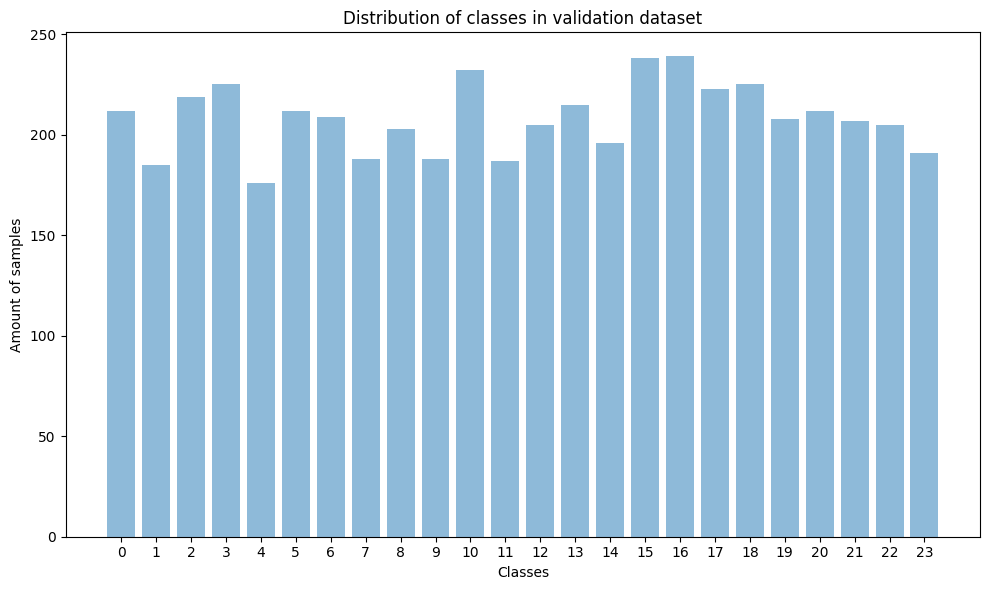

In [38]:
plot_class_distribution_tf(validation_dataset, 'Distribution of classes in validation dataset')

In [39]:
plot_class_distribution_tf(training_dataset, 'Distribution of classes in training dataset')

: 

In [ ]:
plot_class_distribution_tf(testing_dataset, 'Distribution of classes in testing dataset')

# Vizualizing data

### Plotting image examples

In [ ]:
# Plotting training examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(training_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Training dataset examples", fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
# Plotting validation examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(validation_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Validation dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting testing examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(testing_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Testing dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

# Creating Dataloaders

In [ ]:
# Define a set of transformations  
transform_train = transforms.Compose([  
    transforms.ToPILImage(),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(40),  
    transforms.RandomResizedCrop(28, scale=(0.8, 1.2), ratio=(0.75, 1.5), interpolation=InterpolationMode.BILINEAR),  
    transforms.RandomAffine(0, shear=20, scale=(0.8,1.2)),  
    transforms.ToTensor(),  
    #transforms.Normalize((0.5,), (0.5,))  
])  

transform_test_val = transforms.Compose([  
    transforms.ToPILImage(),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])  

In [ ]:
#training_dataset = CustomDataset(training_dataset, transform=transform_train)  
#validation_dataset_transformed = CustomDataset(validation_dataset, transform=transform_test_val)  
#testing_dataset_transformed = CustomDataset(testing_dataset, transform=transform_test_val) 

In [ ]:
torch.manual_seed(RANDOM_SEED)

batch_size = 64

# Use the transformed dataset in your DataLoader  
training_dataloader = DataLoader(  
    training_dataset,  
    batch_size=batch_size,   
    shuffle=True,  
)  

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size, 
    shuffle=False,
)

testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=batch_size, 
    shuffle=False,
)

# Training models and choosing the best one

In [ ]:
best_model = train_and_select_best_model(training_dataloader, validation_dataloader, DEVICE, RANDOM_SEED)

In [ ]:
best_model.eval()

# Making test predictions

In [ ]:
accuracy_test, predictions_test = evaluate_test_by_batch(
    model=best_model, testing_dataloader=testing_dataloader
)
print(f"Test accuracy: {accuracy_test:.4f}")

In [ ]:
nums = np.random.randint(low=0, high=x_test.shape[0], size=10)
fig = plt.figure(figsize=(13, 5))
for i, num in enumerate(nums):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_test[num].numpy().reshape(28, 28), cmap="gray_r")
    ax.set_title(f"True label = {y_test[num].int()} \n Predicted label = {predictions_test[num]}")
plt.suptitle("Random 10 predictions for test set", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
target_names = [
    "A", "B", "C", "D", "E", "F", 
    "G", "H", "I", "K", "L", "M",
    "N", "O", "P", "Q", "R", "S",
    "T", "U", "V", "W", "X", "Y",
]

print(classification_report(
    y_true=y_test, 
    y_pred=predictions_test, 
    target_names=target_names,
)
     )

In [ ]:
save_whole_model(best_model, "../model/sign_mnist_classifier.pt")